# **Lab Report: Monitoring**

### **Student information**
- Student name: Bart Peelman
- Student code: 202410650 / 410650bp

### **Assignment description**
This assignment was about setting up a complete monitoring and alerting stack for both a mocked machine learning model and a real Linux virtual machine. Using Prometheus, Grafana and Alertmanager, the goal was to collect metrics, visualize them in dashboards, and receive alerts when certain thresholds were exceeded. The lab focused on understanding how metrics are exposed, scraped, visualized and used for alerting in a realistic MLOps setup.


#### Lab 5: Monitoring & Alerting

*This report documents the setup, configuration, and validation of a complete monitoring and alerting stack using Prometheus, Grafana, Alertmanager, a mocked ML model, and Node Exporter on a Linux virtual machine.*

#### 5.1 Mocking the model

##### Setup

The mocked model was set up inside a ***Python virtual environment*** to simulate a real ML service exposing Prometheus metrics.

Steps:

- cd monitoring
- python -m venv venv
- source venv/bin/activate
- pip install -r requirements.txt
- python modelmock.py

The virtual environment folder was added to .gitignore to ensure it is not tracked by Git.

##### Verifying metrics exposure

The mocked model exposes its metrics via an HTTP endpoint:

http://localhost:9000/

Refreshing the page multiple times shows the Prometheus metrics output.

❓ Where do you see the metric of the mocked model? What is the exact name of the metric?

- The metric appears in the Prometheus exposition format at the /metrics endpoint. The exact metric name is:
  - model_result

*This value updates whenever the page is refreshed, simulating changing model output.*

#### 5.2 Setting up Prometheus

##### Docker Compose setup

Prometheus was started using Docker Compose. The prometheus.yml configuration file is mapped as a persistent volume so that configuration changes survive container restarts.

Prometheus is accessible at:

http://localhost:9090

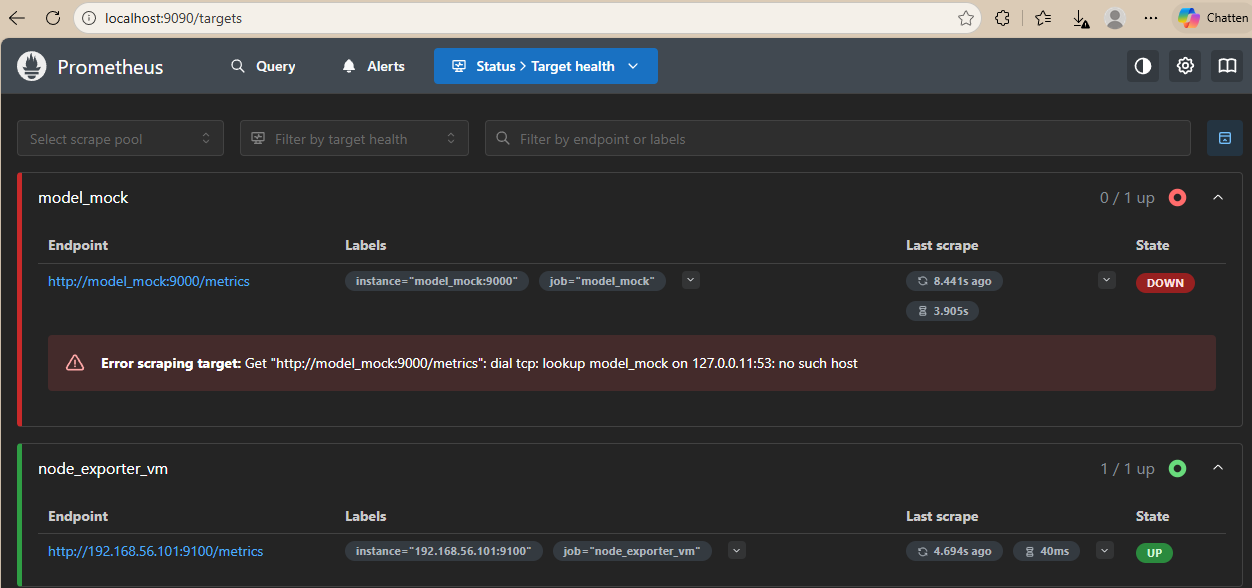

##### Connecting Prometheus to the mocked model

Initially, Prometheus could not reach the mocked model because Docker containers cannot directly access services running on the host machine by default.

❓ Which approach did you choose and why?

I chose to use Docker’s host URL (host.docker.internal) so that the Prometheus container can access the mocked model running on the host. This approach was chosen because:

- It requires minimal changes
- It keeps configuration simple
- It is sufficient for this use case

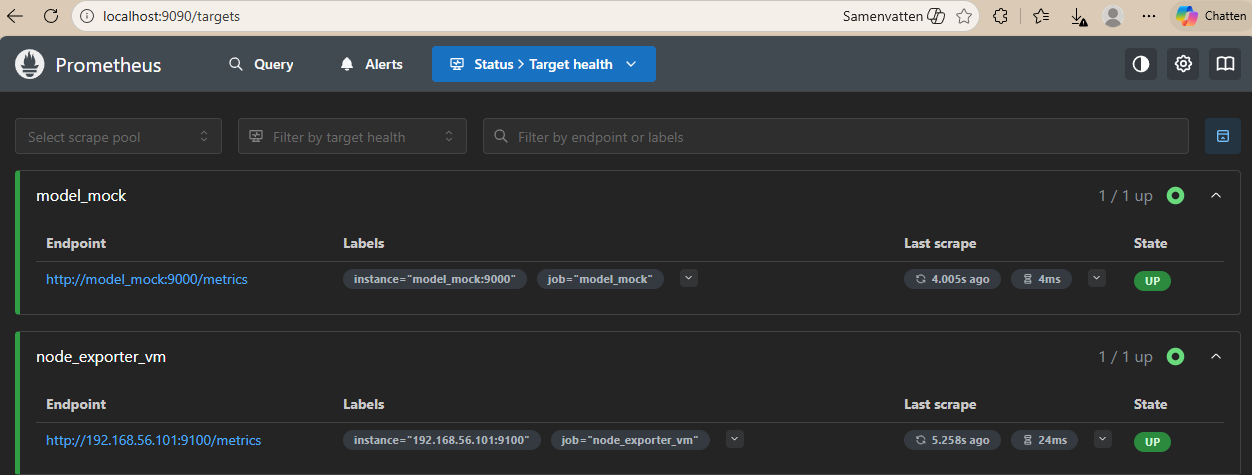

##### Verifying metric ingestion

In the Prometheus UI:

- Status -> Service Discovery confirms the target is discovered

- Status -> Targets shows the target as UP

❓ Query: model_result — can you see the metric? When does it update?

Yes. The model_result metric is visible in both the table and graph view. It updates whenever the mocked model refreshes its value, and that happens on page refresh.

#### 5.3 Grafana

Grafana was added as a Docker Compose service and is accessible at:

http://localhost:3000

The default credentials were used initially and immediately changed after first login.

##### Data source configuration

- Prometheus was added as a data source
- Connection was verified successfully

##### Persistence

Grafana data directories were mapped as Docker volumes to ensure dashboards and configuration persist after restarts. These directories were added to .gitignore.

##### Dashboard creation

*A dashboard was created with the following properties:*

- Displays the model_result metric
- Auto-refresh interval: 5 seconds
- Time range: last 15 minutes
- Red threshold line at y = 0.75

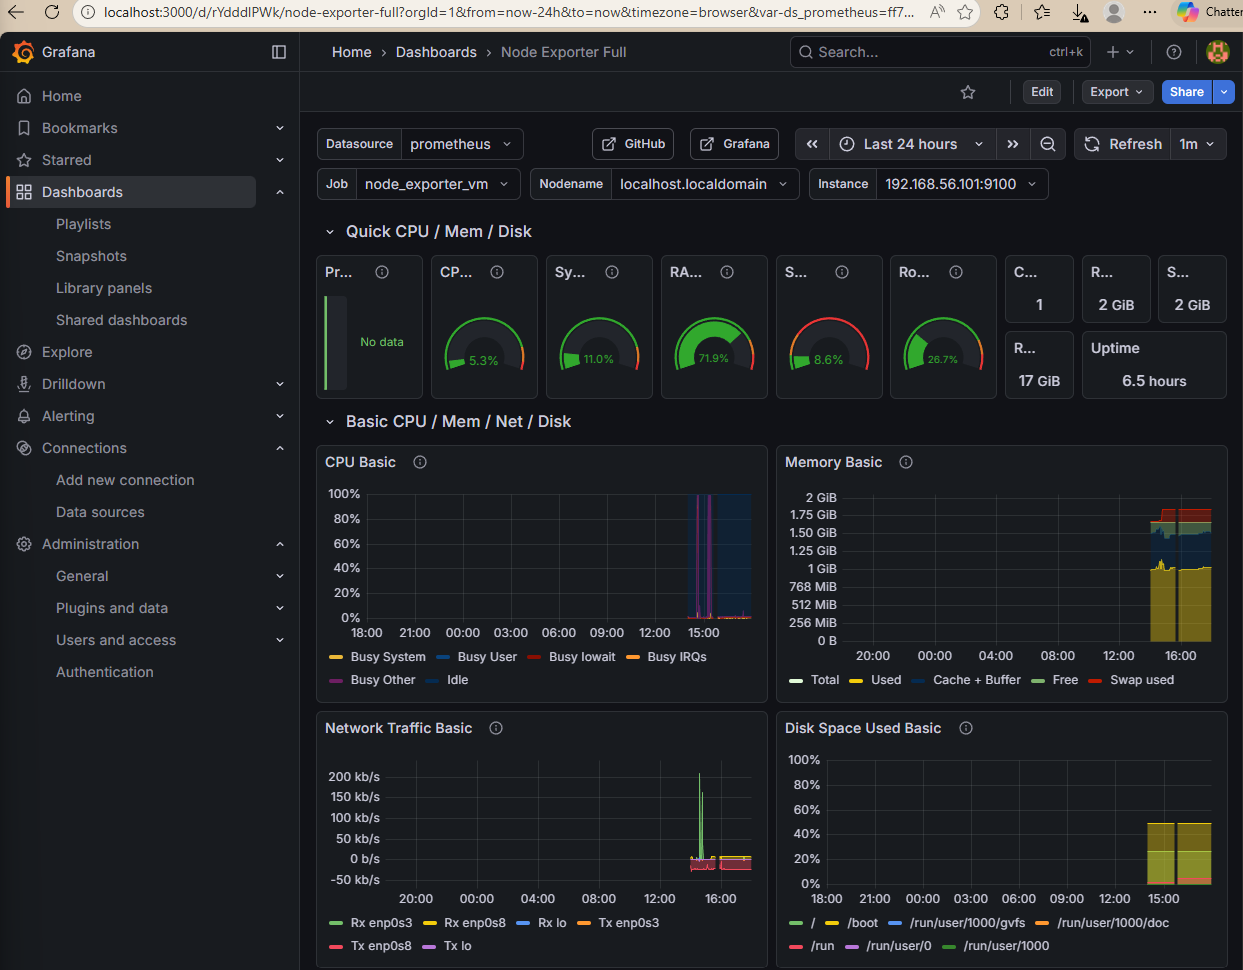

#### 5.4 Alertmanager

##### 5.4.1 Generating alerts

Prometheus alert rules were defined in rules.yml and mapped into the Prometheus container.

*An alert was created that fires when:*

- model_result > 0.75

*Prometheus correctly shows alerts transitioning between:*

- Inactive
- Pending
- Firing

##### Alert lifecycle observation

The alert fires when the metric exceeds the threshold and resolves automatically once the metric drops below it.

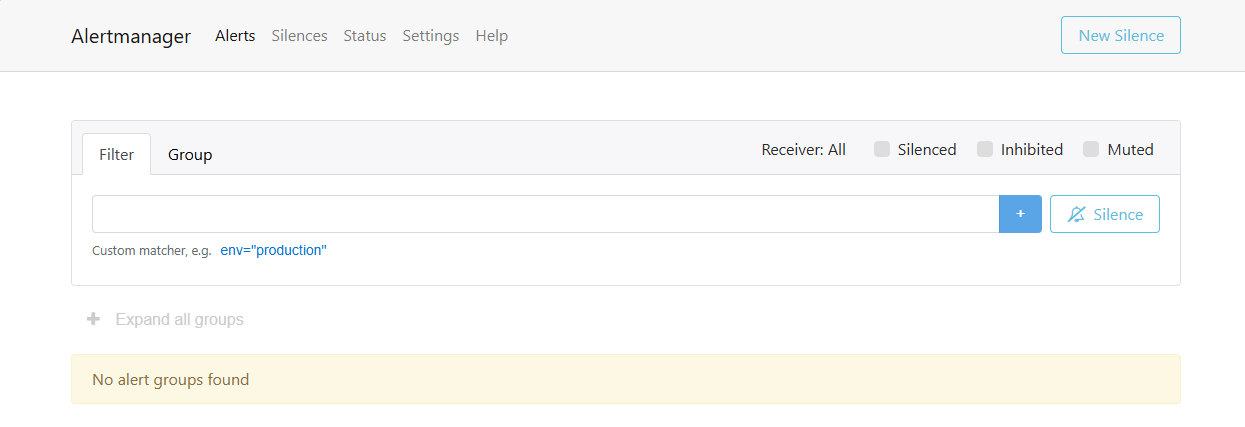

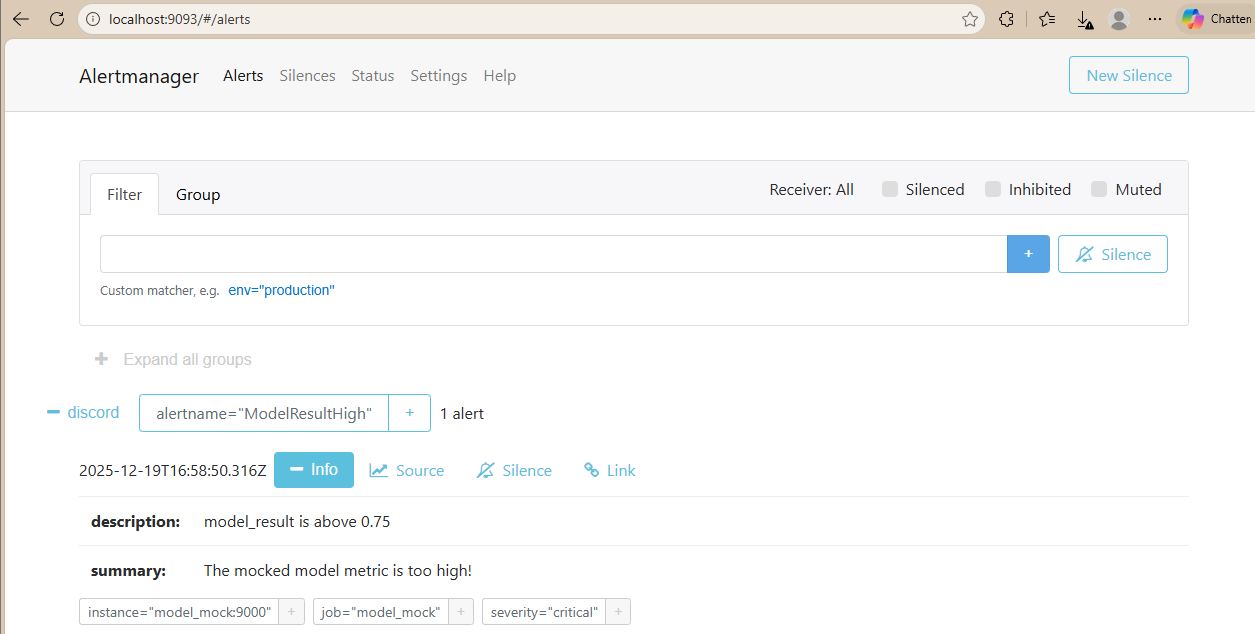

##### 5.4.2 Adding a receiver (Discord)

Alertmanager was configured with a Discord webhook receiver.

❓ What do grouping, inhibition, and silencing mean?

- Grouping: Combines related alerts into a single notification
- Inhibition: Suppresses alerts when a higher-priority alert is already firing
- Silencing: Temporarily disables alerts based on filters and time ranges

Discord notifications were successfully received when alerts were fired.

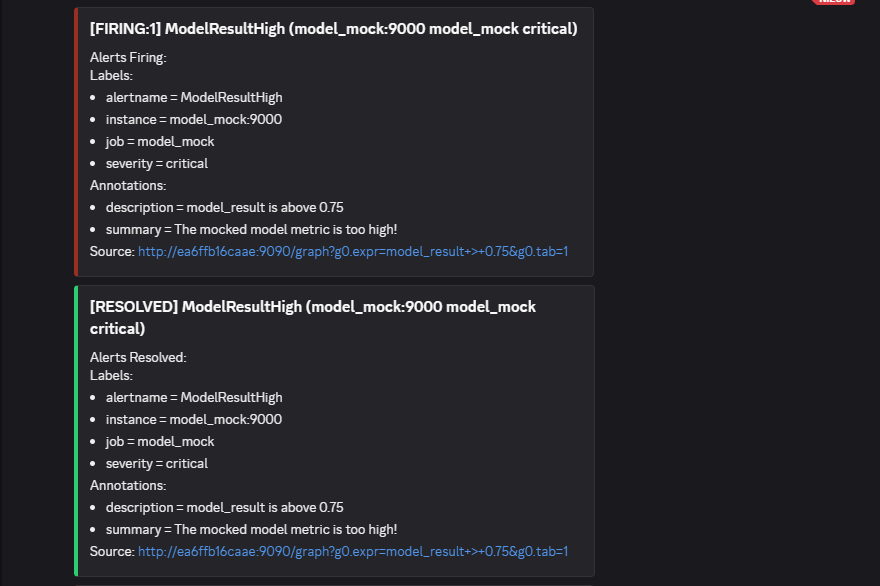


##### 5.5 A more realistic use case – Node Exporter

*The mocked model was stopped, and monitoring was shifted to system-level metrics using Node Exporter.*

##### 5.5.1 Monitoring and visualization

###### VM setup

An AlmaLinux virtual machine was created using NAT + Host-only Adapter networking (not bridged, due to Eduroam limitations).

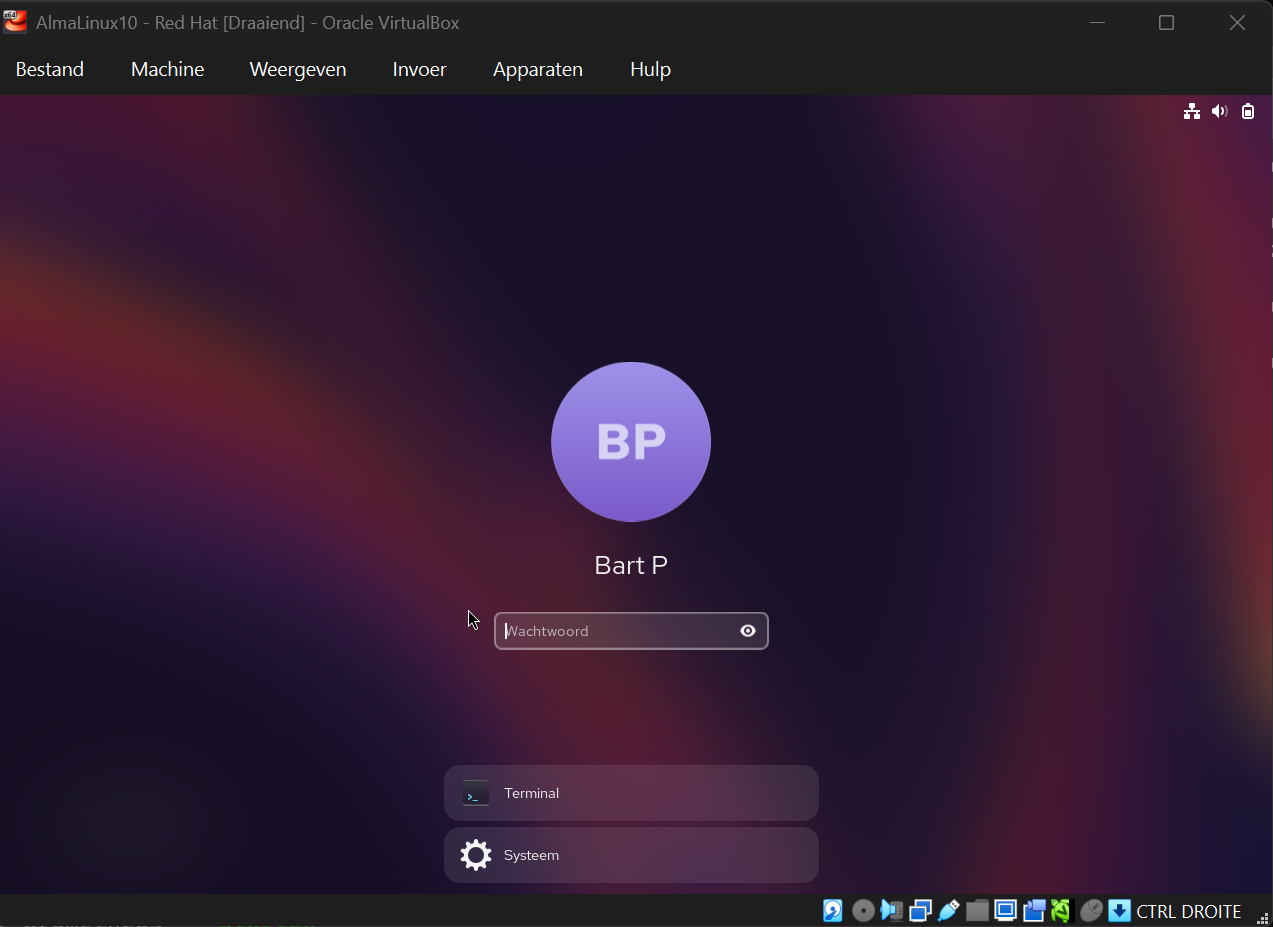

###### Node Exporter installation

Node Exporter was installed using the AlmaLinux repositories:

- sudo dnf install prometheus-node-exporter
- sudo systemctl enable --now prometheus-node-exporter

###### Metric verification

Inside the VM:
- curl localhost:9100/metrics

From the host machine:
- http://<VM-IP>:9100/metrics

Both returned valid metrics output.

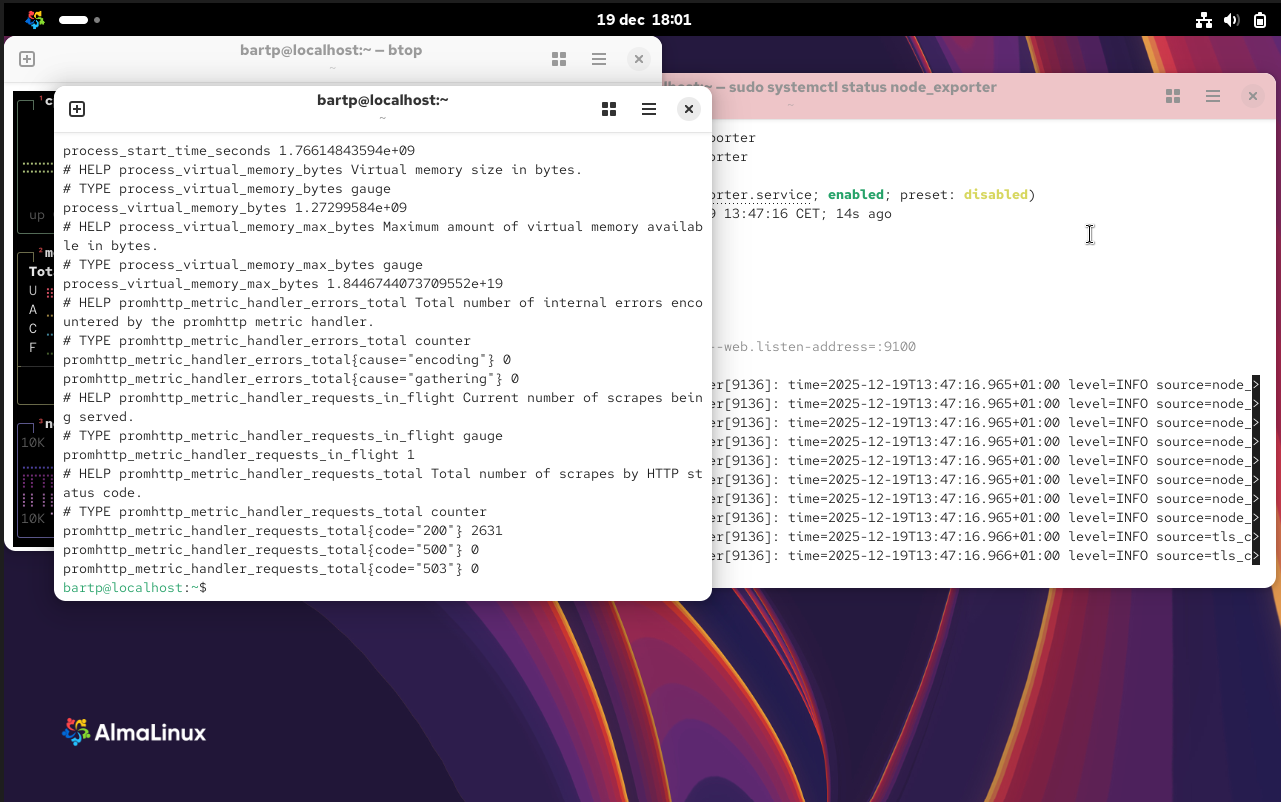

##### Prometheus integration

The VM IP address was added to prometheus.yml as a new scrape target. Prometheus showed the target as UP.

##### Grafana dashboard

The Node Exporter Full dashboard was imported into Grafana. CPU, memory, disk, and network metrics were visualized correctly.

##### Stress testing

Stress testing was performed using stress-ng.
- stress-ng --cpu 1 --timeout 5m

System load was observed using:
- htop
- btop

Results:
- CPU usage reached ~100% in the VM
- Grafana CPU graphs reflected the same behavior in real time

##### 5.5.2 Alerting on CPU usage

A new alert rule was added:
- Threshold: CPU usage > 90%
- Duration: 3 minutes

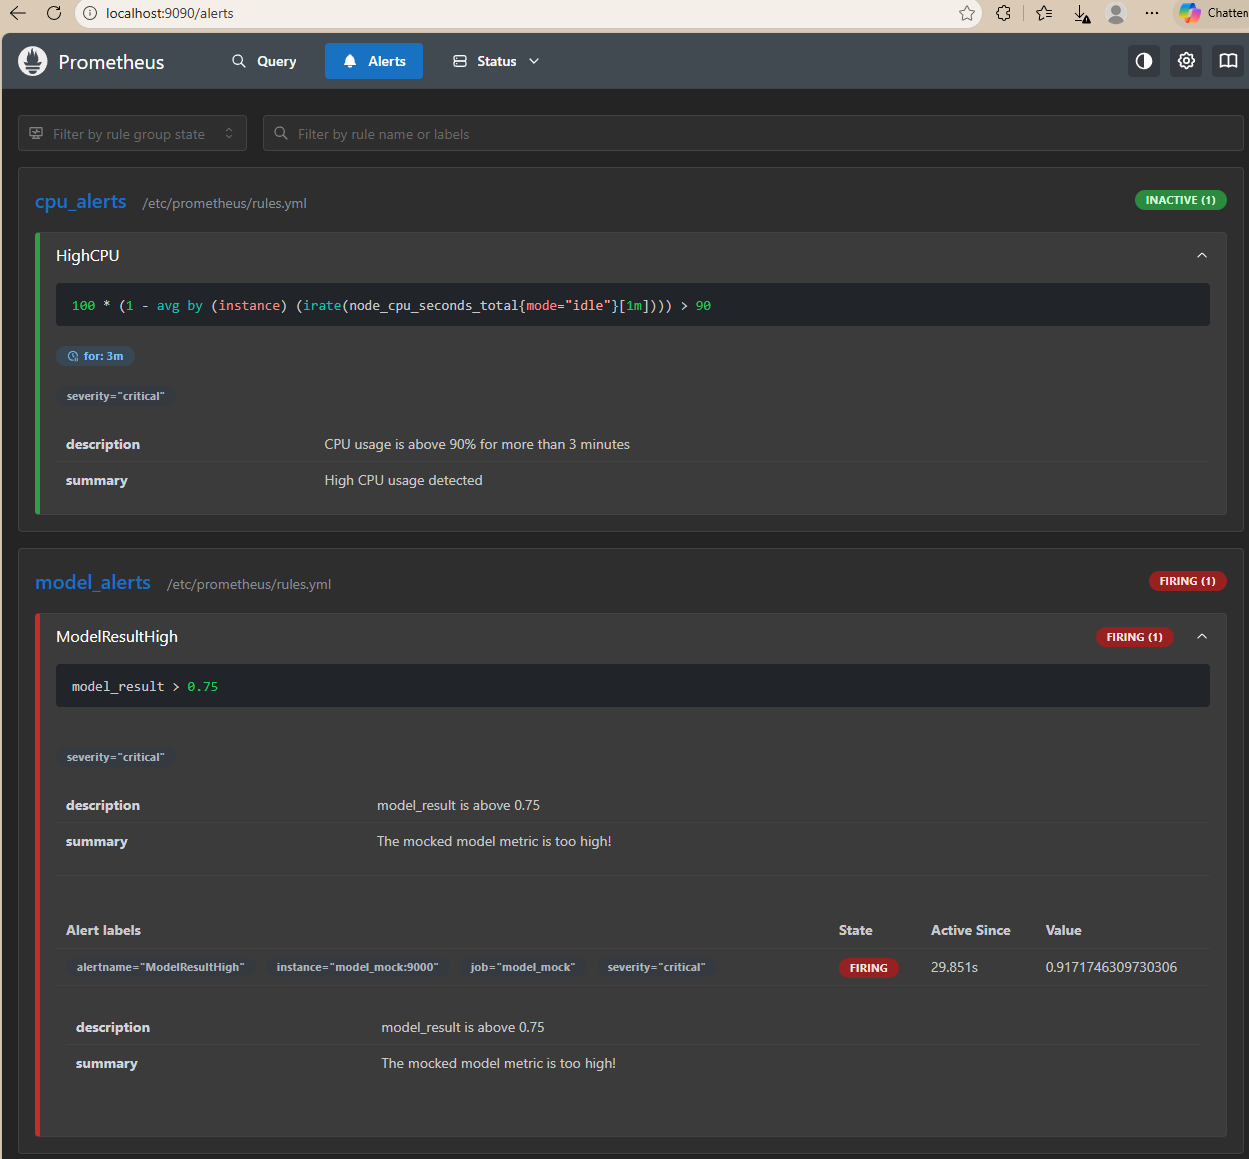

❓ What does for do in an alert rule?

*The for clause specifies how long a condition must remain true before an alert is fired. This helps prevent alerts caused by short spikes.*

##### Alert behavior validation

###### Workflow tested:
- CPU stress for 2 minutes -> ❌ no alert
- CPU stress for 5 minutes -> ✅ alert fired
- Stress stopped -> ✅ resolve alert sent

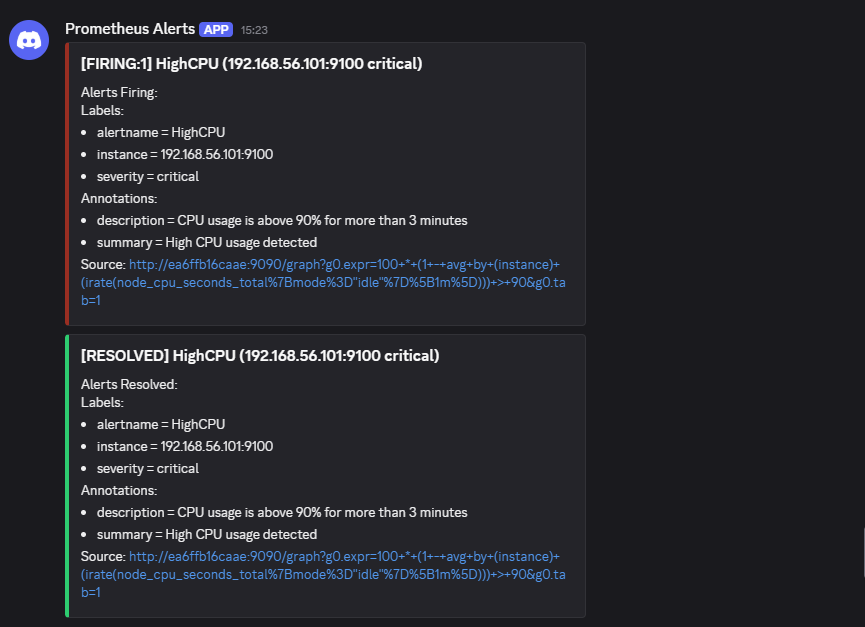

Discord received both firing and resolving notifications, confirming correct behavior.

##### 5.5.3 Alerting fatigue

Alerting fatigue occurs when too many false positives reduce trust in alerts. False negatives, on the other hand, hide real problems.

### **Evaluation criteria**
###### Model mock
- ✅ Show that your mocked model is running in a Python virtual environment and that you can access it's metrics by HTTP
- ✅ Show that Prometheus receives the mocked model's metric
- ✅ Show that Grafana receives the mocked model's metric
  - ✅ The dashboard should refresh every 5 s
  - ✅ The dashboard shows the history of the past 15 min
  - ✅ The graph shows a red threshold line at y=0.75
- ✅ Show that you receive alerts about the mocked model metric through Discord

###### Node exporter
- ✅ Show that Node Exporter is running on the VM and that you can access its metric's by HTTP
- ✅ Show that you can see the CPU going to 100% by using stress-ng with htop/btop on the CLI of the VM.
- ✅ Show that you don't receive an alert if the CPU is high for 2 min, but do receive an alert if the CPU is high for 4 min
  - ✅ Also show that you can check these CPU values in Grafana
  - ✅ Also show that you receive a resolve alert when the CPU load drops after the 4 min of high load

##### General
- ✅ Show that you wrote an elaborate lab report in Markdown and pushed it to the repository
  - ✅ Provide an answer to all questions marked with ❓
  - ✅ Discuss the answers during the demo session
- ✅ Show that you updated the cheat sheet with the commands you need to remember



### **Issues**
- ***Docker networking:*** Prometheus initially couldn’t reach the mocked model because Docker containers can’t access host services by default. This required using host.docker.internal and understanding Docker’s internal networking.

- ***Alertmanager configuration:*** Alerts were firing in Prometheus but not arriving in Discord due to incorrect Alertmanager configuration and missing resolve settings.

- ***Prometheus reloads:*** After changing prometheus.yml or rules.yml, forgetting to reload Prometheus caused confusion when changes didn’t take effect immediately.

- ***Node Exporter installation:*** Installing Node Exporter on AlmaLinux was more difficult than I expected. The packaged version wasn’t available by default, and the manual installation caused issues with paths, permissions, and systemd services.

- ***Systemd service issues:*** Node Exporter worked when started manually but failed as a service due to incorrect paths and execution permissions, which made debugging very time-consuming.

- ***Firewall and networking on the VM:*** Even when Node Exporter was running, Prometheus couldn’t reach it until the firewall was opened and a Host-only network adapter was configured.

- ***Alert timing:*** Alerts did not trigger immediately due to the for: duration in Prometheus rules, which initially looked like a misconfiguration but turned out to be expected behavior.

### **Reflection**
During this lab, the most difficult part was getting all components to communicate correctly with each other. Networking between Docker containers, the host machine and the virtual machine caused several issues, especially with accessing Node Exporter from the host and Prometheus. Installing and running Node Exporter on AlmaLinux also took more time than expected due to service configuration and permission issues.

Another challenge was troubleshooting alerting behaviour, such as alerts not firing immediately or not resolving as expected. This required a good understanding of Prometheus alert rules, the for clause, and how Alertmanager handles notifications. Once everything was configured correctly, the monitoring and alerting workflow became much clearer and easier to understand.

*Running the mocked model directly in WSL caused HTTP framing issues between WSL and Windows. To ensure reproducibility and reliable Prometheus scraping, the mocked model, I containerized and added to Docker Compose, allowing Prometheus to scrape it over the internal Docker network.*

### **Resources**
- Prometheus documentation:
https://prometheus.io/docs/

- Grafana documentation:
https://grafana.com/docs/

- Alertmanager documentation:
https://prometheus.io/docs/alerting/latest/alertmanager/

- Node Exporter documentation:
https://prometheus.io/docs/guides/node-exporter/

- Awesome Prometheus Alerts:
https://samber.github.io/awesome-prometheus-alerts/

- Discord Webhooks documentation:
https://support.discord.com/hc/en-us/articles/228383668-Intro-to-Webhooks